In [26]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import random
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, classification_report,confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from keras import losses,optimizers,utils
from matplotlib import pyplot as plt
%matplotlib inline

### Data pre-processing

In [2]:
with open('data.p', 'rb') as fp:
    data = pickle.load(fp)

In [3]:
seed =15
participants = list(data.keys())
random.seed(seed)
random.shuffle(participants)
p_train = participants[:100]
p_val = participants[100:125]
p_test = participants[125:145]

In [4]:
task = 'sedentary'

In [5]:
X_train,Y_train,X_val,Y_val,X_test,Y_test = [],[],[],[],[],[]

In [6]:
for p1 in p_train:
    X_train.extend(data[p1][0])
    Y_train.extend(data[p1][1])
Y_train = np.asarray(Y_train,dtype=np.str)

for p2 in p_val:
    X_val.extend(data[p1][0])
    Y_val.extend(data[p1][1])
Y_val = np.asarray(Y_val,dtype=np.str)

for p3 in p_test:
    X_test.extend(data[p1][0])
    Y_test.extend(data[p1][1])
Y_test = np.asarray(Y_test,dtype=np.str)

In [7]:
Y_train = np.where(Y_train==task,1,0)
Y_val = np.where(Y_val==task,1,0)
Y_test = np.where(Y_test==task,1,0)

In [8]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [9]:
train_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
val_weights = class_weight.compute_class_weight('balanced',np.unique(Y_val),Y_val)

### keras model

In [10]:
inputs = Input(shape=(480,3))
conv1 = Conv1D(32, 8, strides =1 , padding='same', activation='relu')(inputs)
conv2 = Conv1D(32, 8, strides =1 , padding='same', activation='relu')(conv1)
lstm1 = LSTM(32)(conv2)
output = Dense(1,activation='sigmoid')(lstm1)
model = Model(inputs=inputs,outputs= output)

W0913 15:59:18.774735 140362927990592 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 15:59:18.799166 140362927990592 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 15:59:18.806791 140362927990592 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [11]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])
checkpoint = ModelCheckpoint('weight.h5', monitor='binary_accuracy',save_best_only=True,mode='max')
history = model.fit(X_train, Y_train,batch_size=32,validation_data=(X_val,Y_val),
          class_weight=train_weights,epochs=5,callbacks=[checkpoint])

W0913 15:59:19.743307 140362927990592 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0913 15:59:19.755517 140362927990592 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0913 15:59:19.758169 140362927990592 deprecation.py:323] From /home/subhashnerella/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0913 15:59:20.191733 140362927990592 deprecation_wrapper.py:119] From /home/subhashnerella/anaconda3/envs

Train on 68555 samples, validate on 20950 samples
Epoch 1/5
68555/68555 [==============================] - 877s 13ms/step - loss: 0.1608 - binary_accuracy: 0.9370 - val_loss: 0.1307 - val_binary_accuracy: 0.9463
Epoch 2/5
68555/68555 [==============================] - 868s 13ms/step - loss: 0.1279 - binary_accuracy: 0.9474 - val_loss: 0.1143 - val_binary_accuracy: 0.9523
Epoch 3/5
68555/68555 [==============================] - 867s 13ms/step - loss: 0.1311 - binary_accuracy: 0.9474 - val_loss: 0.1308 - val_binary_accuracy: 0.9582
Epoch 4/5
68555/68555 [==============================] - 867s 13ms/step - loss: 0.1383 - binary_accuracy: 0.9474 - val_loss: 0.1352 - val_binary_accuracy: 0.9463
Epoch 5/5
68555/68555 [==============================] - 861s 13ms/step - loss: 0.1194 - binary_accuracy: 0.9520 - val_loss: 0.1140 - val_binary_accuracy: 0.9630


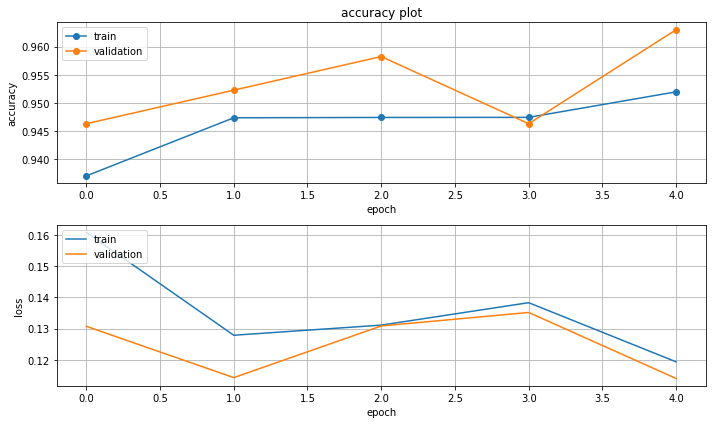

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(history.history['binary_accuracy'],marker='o')
plt.plot(history.history['val_binary_accuracy'],marker='o')
plt.grid(True)
plt.title('accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(212)
plt.grid(True)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()

In [13]:
Y_pred = model.predict(X_test,batch_size = 32)

In [14]:
fpr, tpr, thresholds=roc_curve(Y_test,Y_pred,pos_label=1)
area = auc(fpr,tpr)

In [15]:
print ('aUC = %0.2f' %area)

aUC = 0.98


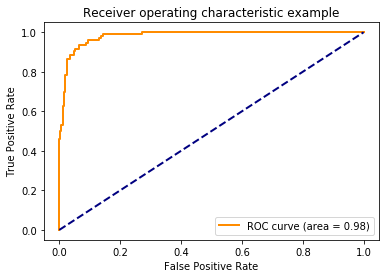

In [16]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' %area)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [17]:
Y_pred1 = Y_pred
Y_pred1[Y_pred>=0.5]=1
Y_pred1[Y_pred<0.5]=0
classes = ['non-seden','seden']
print(classification_report(Y_test,Y_pred,target_names=classes))

              precision    recall  f1-score   support

   non-seden       0.98      0.98      0.98     14840
       seden       0.82      0.86      0.84      1920

    accuracy                           0.96     16760
   macro avg       0.90      0.92      0.91     16760
weighted avg       0.96      0.96      0.96     16760



In [23]:
confusion_matrix(Y_test, Y_pred1)

array([[14480,   360],
       [  260,  1660]])

In [27]:
balanced_accuracy_score(Y_test, Y_pred1)

0.9201622866127583